In [1]:
# For IceCube Data analysis .... 
# This is for Data analysis the example basic is for Sensitivity 


In [2]:
# imports
from constants import pdm_constants as const
from config import config
from pone_aeff import Aeff
from dm2nu import DM2Nu
from atm_shower import Atm_Shower
from detectors import Detector
import numpy as np
import matplotlib.pyplot as plt
from limit_calc import Limits
from bkgrd_calc import Background
from signal_calc import Signal
from pdm import PDM
from scipy.interpolate import UnivariateSpline
from scipy.stats import chi2
from scipy.stats import *
from scipy import optimize
from scipy.odr import ODR, Model, Data, RealData
from pylab import *
from pone_aeff import Aeff
import pickle
import csv
from scipy.stats import poisson
from matplotlib import rc
from CL_s import *

In [4]:
# picture path
PICS = '../pics/'
name=[r'$\nu_{\mu}$', r"$\nu_e$", r"$\nu_{\tau}$"]  # ,r'$\nu_{e}$',r'$\nu_{\tau}$'
# Plotting standards
std_size = 6.  # Size of the plot
fontsize = 15.  # Fontsize in the plot
lw=0.5  # Linewidth
h_length=0.5  # Handle length for the legends
export_dpi = 500  # Dpi for the image export
color_pone='#7570b3'
color_ice='#e7298a'
color_combined='#33a02c'
color_thermal='#1f78b4'
color_unitary='k'
color_4='#1b9e77'
color_6='#d95f02'
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

In [5]:
surface_fluxe = pickle.load(open("../data/" +
                                                   "surf_store_v1.p", "rb"))

In [6]:
projection_ice = pickle.load(open('../data/background_ice.pkl','rb'))
signal_ice =pickle.load(open("../data/limits_signal_IceCube.pkl", "rb"))


projection_pone = pickle.load(open('../data/background_pone_unsm.pkl','rb'))

In [7]:
len(projection_pone['numu'])

121

In [8]:
#for i in projection_ice.keys():
#    projection_ice[i]=np.sum(projection_ice[i], axis=0)

In [9]:
e_grid = surface_fluxe[0][0]
e_width = surface_fluxe[0][1]
def width2grid(a: np.array):
    m_a = []
    for i, e in enumerate(a):
        if i == 0:
            m_a.append(e)
        elif i==len(a)-1:
            print(i)
            break
        else:
            m_a.append((a[i] + a[i+1]) / 2)

    return np.array(m_a)

In [10]:
e_grid_bin = width2grid(e_grid)

120


In [11]:
def astro_flux():
     res = 1.66 * (e_grid / 1e5)**(-2.6) * 1e-18  # Custom
     return res

In [12]:
def ice_parser(filename):
    
        store = []
        with open(filename, newline='') as csvfile:
            reader = csv.reader(csvfile)
            for row_num, row in enumerate(reader):
                if row_num == 0:
                    continue
                store.append(row[0].split())
        store = np.array(store, dtype=float)

        return store

In [13]:


def data_filter(event_dic, energy_range, angle_range, years):
    # filters the data in energy and angle
    filtered_dic = {}
    for year in years:
        # where method is faster as basic slicing
        energy_filter_1 = event_dic[year][np.where(event_dic[year][:, 1] < energy_range[1])]
        energy_filter_2 = energy_filter_1[np.where(energy_filter_1[:, 1] > energy_range[0])]
        high_angle = angle_range[1]
        angle_filter_1 = energy_filter_2[np.where(energy_filter_2[:, 4] < high_angle)]
        low_angle = angle_range[0]
        angle_filter_2 = angle_filter_1[np.where(angle_filter_1[:, 4] > low_angle)]
        filtered_dic[year] = angle_filter_2
    return filtered_dic



In [14]:
bkgrd_ice_data = [
                        '../data/icecube_10year_ps/events/IC40_exp.csv',
                        '../data/icecube_10year_ps/events/IC59_exp.csv',
                        '../data/icecube_10year_ps/events/IC79_exp.csv',
                        '../data/icecube_10year_ps/events/IC86_I_exp.csv',
                        '../data/icecube_10year_ps/events/IC86_II_exp.csv',
                        '../data/icecube_10year_ps/events/IC86_III_exp.csv',
                        '../data/icecube_10year_ps/events/IC86_IV_exp.csv',
                        '../data/icecube_10year_ps/events/IC86_V_exp.csv',
                        '../data/icecube_10year_ps/events/IC86_VI_exp.csv',
                        '../data/icecube_10year_ps/events/IC86_VII_exp.csv',
                    ]
bkgrd_ice_dic = {
                        0: ice_parser(bkgrd_ice_data[0]),
                        1: ice_parser(bkgrd_ice_data[1]),
                        2: ice_parser(bkgrd_ice_data[2]),
                        3: ice_parser(bkgrd_ice_data[3]),
                        4: ice_parser(bkgrd_ice_data[4]),
                        5: ice_parser(bkgrd_ice_data[5]),
                        6: ice_parser(bkgrd_ice_data[6]),
                        7: ice_parser(bkgrd_ice_data[7]),
                        8: ice_parser(bkgrd_ice_data[8]),
                        9: ice_parser(bkgrd_ice_data[9]),
                    }

In [15]:
ice_tmp_data_dic = data_filter(bkgrd_ice_dic, [2,8], [0,90], range(0,10))

In [16]:
ice_data_dic = {}

for i in bkgrd_ice_dic.keys():
    tmp_hist_data, bins_edge = np.histogram(ice_tmp_data_dic[i][:,1], bins=np.log10(e_grid) )
    ice_data_dic[i] = tmp_hist_data

In [49]:
ice_d = []
for i in range(0,10):
    ice_d.append(ice_data_dic[i])
ice_d = np.sum(ice_d, axis=0)

In [50]:
# projection_ice["numu"] = np.sum(projection_ice["numu"][3:],axis=0)

In [51]:
# q_single_b(projection_ice["numu"][45:70], ice_d[45:70])

In [52]:
l = range(0,10)

In [53]:
np.array(l)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [54]:
def _find_nearest(array: np.array, value: float):
    
    """ Returns: index of the nearest vlaue of an array to the given number
    --------------
    idx :  float
    """
    array = np.array(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [55]:
_find_nearest(e_grid, 5e2), _find_nearest(e_grid, 1e6)

(37, 70)

In [56]:
np.log10(ice_data_dic[1][38:67])

array([2.31806333, 2.8286599 , 3.3960249 , 3.67292869, 3.80875097,
       3.85144181, 3.74849813, 3.69609416, 3.47567119, 3.31302311,
       3.17609126, 2.97358962, 2.92116605, 2.6919651 , 2.67851838,
       2.58433122, 2.29885308, 2.24797327, 2.08635983, 1.96848295,
       1.93449845, 1.65321251, 1.61278386, 1.34242268, 1.2787536 ,
       1.        , 0.60205999, 0.        , 0.77815125])

In [57]:
def fit_fun_gamma(A, E, gamma, phi_0):
    return (A*(E)**(-gamma) + phi_0)



In [58]:
para = {}
p = {}

para_fun = {}
p_fun = {}
phi_fits = {}
new_phi = {}
phi_fun = {}
# 5.11951803,   15.42169565, 2821.23529455]
# [ 1.56906855e-01, -2.63388990e+02,  1.01791398e+00]
#
for i in range(0,9):
    new_phi[i] = []
    phi_fun[i] = []
    phi_fits[i] = []
    if i==0:
        spl_phi = UnivariateSpline(e_grid, projection_ice['numu'][i], k=1, s=1)
        def fit_phi(E, A, E_0, b):
            return np.log10(spl_phi(E + E_0 )*A + b)
        t_para, _p = optimize.curve_fit(fit_phi, e_grid_bin[40:66], np.log10(ice_data_dic[i][40:66]),
                                        method='dogbox')
        para[i] = t_para
        p[i]= _p

    elif i==1:
        spl_phi = UnivariateSpline(e_grid, projection_ice['numu'][i], k=1, s=1)
        def fit_phi(E, A, E_0, b):
            return np.log10(spl_phi(E + E_0 )*A + b)
        t_para, _p = optimize.curve_fit(fit_phi, e_grid_bin[40:67], np.log10(ice_data_dic[i][40:67]))
        para[i] = t_para
        p[i]= _p

    elif i==2:
        spl_phi = UnivariateSpline(e_grid, projection_ice['numu'][i], k=1, s=1)
        def fit_phi(E, A, E_0, b):
            return np.log10(spl_phi(E + E_0 )*A + b)
        t_para, _p = optimize.curve_fit(fit_phi, e_grid_bin[38:60], np.log10(ice_data_dic[i][38:60]))
        para[i] = t_para
        p[i]= _p

    else:
        spl_phi = UnivariateSpline(e_grid, projection_ice['numu'][i], k=1, s=1)
        def fit_phi(E, A, E_0, b):
            return np.log10(spl_phi(E + E_0 )*A + b)
        t_para, _p = optimize.curve_fit(fit_phi, e_grid_bin[38:57], np.log10(ice_data_dic[i][38:57]), method='dogbox')
        para[i] = t_para
        p[i]= _p

    phi_fits[i].extend(fit_phi(e_grid, *para[i]))
    new_phi[i].extend(10**(fit_phi(e_grid, *para[i])))

    # phi_fun[i].extend((fit_fun_gamma(e_grid, *para_fun[i])))

/tmp/ipykernel_4251/1548751189.py:44: RuntimeWarning: invalid value encountered in log10
  return np.log10(spl_phi(E + E_0 )*A + b)


In [59]:
para, para_fun

({0: array([ 1.86275341e-01, -4.04958319e+02,  1.05871364e+00]),
  1: array([ 3.29827067e-01, -3.72631565e+02,  1.23709351e+01]),
  2: array([  31.74564461, 8277.3657072 ,   10.72705184]),
  3: array([   2.2981199 , 1374.48328754,    2.8405676 ]),
  4: array([   2.55846528, 1378.90418311,   -3.76694954]),
  5: array([   2.80770673, 1406.89313043,   -4.94606431]),
  6: array([2.57828940e+00, 1.29939170e+03, 9.25592107e-01]),
  7: array([   2.27858036, 1143.13585846,   -3.81336496]),
  8: array([ 2.26631824e+00,  1.32272530e+03, -4.07588214e-01])},
 {})

In [60]:
phi_fit = []
for i in range(0,9):
     phi_fit.append(new_phi[i])

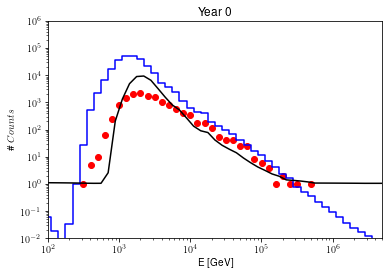

In [61]:
for i in range(0, 9):
    plt.figure()
    plt.title('Year %d ' % (i))
    plt.step(e_grid, projection_ice['numu'][i], color='b' )
    plt.plot(e_grid, new_phi[i], color='k')
    #plt.plot(e_grid, phi_fun[i], color='g')
    #plt.step(e_grid, projection_pone['numu'][i], color='k' )
    plt.scatter(e_grid_bin, ice_data_dic[i], color='r')
    #plt.plot(e_grid[32:50], ice_data_dic[i][32:50], color='g')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim(1e-2,1e6)
    plt.xlim(1e2,5e6)
    plt.xlabel(r'E [GeV] ')
    plt.ylabel(r'\# $Counts$')
#    plt.savefig("../pics/IceCube_counts_%d.png" % (i), facecolor="white")
    break


In [62]:
spl_phi = UnivariateSpline(e_grid, np.sum(np.array(projection_ice['numu'][3:]), axis=0), k=1, s=0) # The projection_ice / ice_dneeds to be changed to total sum ...... 
np.log10(ice_d)[np.log10(ice_d) == -np.inf] = 0
def fit_phi(E, A, E_0):
          return (A * spl_phi(E + E_0 ))
t_para, _p = optimize.curve_fit(fit_phi, e_grid_bin[38:70], np.nan_to_num((ice_d))[38:70],[   1.67881964, 1140.13585799], bounds=[[1, 20],[3, 3000]], method='dogbox')

/tmp/ipykernel_4251/1771748151.py:2: RuntimeWarning: divide by zero encountered in log10
  np.log10(ice_d)[np.log10(ice_d) == -np.inf] = 0


In [63]:
t_para # array([2.20735973e+00, 2.91299035e+03]) for 0-9 years 
# array([   1.67881964, 1143.13585799,    2.        ]) for 3-9 years

array([   2.01628805, 1143.13585671])

In [64]:
def odr_fit_phi(A, x):
    return (A[0] * spl_phi(x + A[1] ) + A[2])


In [65]:
odr_model = Model(odr_fit_phi)
odr_data = RealData(e_grid[36:71], ice_d[36:71])


In [66]:
odr_fit = ODR(odr_data, odr_model, beta0=[2.00735973e+00, 2.91299035e+03, 1])

In [67]:
odr_fit.set_job(fit_type=0)

In [68]:
odr_out = odr_fit.run()

In [69]:
odr_out.beta


array([   4.75782784, 1738.85283695,  157.28675168])

In [70]:
fit_phi_odr = odr_fit_phi(odr_out.beta, e_grid_bin)

In [71]:
ice_d_spl = UnivariateSpline(e_grid_bin, ice_d, k=1, s=0)(e_grid)

In [72]:
ice_d_spl[46:67], ice_d[46:70]

(array([2.01460287e+04, 1.16888110e+04, 7.54484406e+03, 4.90509342e+03,
        3.31603912e+03, 2.33876199e+03, 1.46352555e+03, 1.15625272e+03,
        7.53940458e+02, 4.69335889e+02, 3.53731163e+02, 2.57715359e+02,
        1.88849777e+02, 1.27043424e+02, 7.26877396e+01, 5.49327908e+01,
        3.56877396e+01, 2.28023629e+01, 1.27865582e+01, 9.11462327e+00,
        8.44268837e+00]),
 array([13966,  8822,  5937,  3606,  2951,  1568,  1332,   935,   526,
          398,   298,   207,   166,    78,    66,    41,    29,    15,
           10,     8,     9,     2,     1,     0]))

In [73]:
print("low = %.1e, high = %.1e," % (e_grid[46], e_grid[70]))

low = 3.5e+03, high = 8.9e+05,


In [74]:
aa= np.array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,])

In [75]:
e_grid[50]

8912.509381337459

In [76]:
p_CL_b = poisson.pmf(ice_d[32:], fit_phi_odr[32:]) # q_single_b from CL_s
p_CL_ob = poisson.pmf(ice_d[32:], ice_d[32:])

In [77]:
p_CL_b, p_CL_ob

(array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 2.04181603e-049,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 3.19568920e-237,
        4.23252036e-158, 3.13239565e-062, 5.70808603e-169, 8.37056448e-038,
        3.43854367e-095, 9.61344890e-062, 9.99965588e-015, 2.04880193e-010,
        1.72424845e-005, 2.76958986e-002, 6.83573364e-003, 1.63724813e-017,
        2.42281870e-020, 1.75765921e-031, 1.79107195e-038, 7.42696316e-050,
        8.69299245e-055, 7.11555254e-057, 2.13012590e-055, 2.29956061e-065,
        3.81721644e-067, 3.05258291e-069, 4.42315526e-065, 3.88134962e-069,
        6.55982587e-067, 4.36711713e-069, 4.53548489e-069, 4.64878125e-069,
        4.71411371e-069, 4.77538510e-069, 4.81758023e-069, 4.84292371e-069,
        4.86368541e-069, 4.87749058e-069, 4.88936188e-069, 4.89799260e-069,
        4.90

In [78]:
(q_single_b(fit_phi_odr[51:71], ice_d[50:70]))


array([0.00000000e+000, 8.53709477e-166, 2.18008930e-194, 1.98400559e-130,
       1.24988846e-034, 2.38210376e-020, 2.95771622e-008, 4.52635275e-001,
       6.68327506e-001, 1.61050038e-014, 7.55047905e-018, 2.77000968e-029,
       1.22014280e-036, 2.47980829e-048, 1.60250698e-053, 8.65494175e-056,
       2.39302820e-054, 1.11409581e-064, 1.30907765e-066, 3.56126470e-069])

In [79]:
print('logical low E cutoff from above = %.1e' % (e_grid[52]))

logical low E cutoff from above = 1.4e+04


In [80]:
mass_grid = enumerate(np.logspace(2, 6, 9))
sv_grid = enumerate(np.logspace(-26, -21, 9))
# print("sv_index = %f, mass_index = %f" % (s, m))
CLs_, prob = CL_scan(signal_ice[:,:,51:71], fit_phi_odr[51:71], ice_d[50:70], sv_grid, mass_grid, sample_count=10000)
print("CLs")
print(CLs_)
print("prob Mat")
print(prob)


0it [00:00, ?it/s]/home/kruteesh/Desktop/DM_nu_simulation_P-One/PONE_git/pone_work/pone_dm/CL_s.py:10: RuntimeWarning: invalid value encountered in true_divide
  return poisson.pmf(b_obs, b_sim + s) / poisson.pmf(b_obs, b_sim)
0it [00:20, ?it/s]


KeyboardInterrupt: 

In [93]:
std_size

6.0

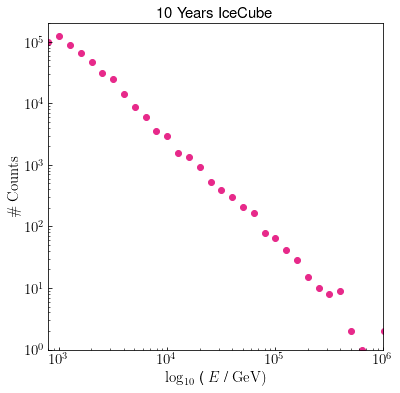

In [105]:
figure, ax1 = plt.subplots(1,1,figsize=(std_size,std_size), sharex=True) 
ax1.set_title(r'10 Years IceCube ', fontsize=fontsize)
ax1.scatter(e_grid_bin, ice_d, color=color_ice, label="Data")

ax1.set_xscale('log')
ax1.set_yscale("log")
ax1.set_xlim(0.8e3,1e6)

ax1.set_ylim(1e0,2e5)
ax1.set_xlabel(r'$\log_{10}$ ( $E$ / $ \textrm{GeV} )$ ', fontsize=fontsize)

ax1.set_ylabel(r'$\#$ $\textrm{Counts}$', fontsize=fontsize)

ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')

figure.savefig(PICS + "background_IceCube_10"+".png",
               bbox_inches='tight', dpi=export_dpi, facecolor='white')


In [91]:
pickle.dump([e_grid_bin, ice_d], open('../data/background_ice_10.pkl', 'wb'))

In [ ]:
odr_fit.restart()

This is the Poissonian CL

In [ ]:
tmp_pois = np.abs(ice_d[35:70] - fit_phi(e_grid_bin, *t_para)[35:70]) / fit_phi(e_grid_bin, *t_para)[35:70]**(1/2)
tmp_odr = np.abs(ice_d[35:70] - fit_phi_odr[35:70]) / fit_phi_odr[35:70]**(1/2)

In [ ]:

e_grid[46]

3548.133892335757

In [ ]:
_find_nearest(e_grid, 3000)

45

In [ ]:
odr_p = (poisson.pmf(ice_d[46:], fit_phi_odr[46:]))
odr_d = poisson.pmf(ice_d[30:70], ice_d[30:70])
p_p = (poisson.pmf(ice_d[50:70], fit_phi(e_grid_bin, *t_para)[50:70]))
p_d = poisson.pmf(ice_d[0:80], ice_d[0:80])

In [ ]:
odr_d

array([0.03049301, 0.01876121, 0.01766257, 0.01343944, 0.00899705,
       0.00538955, 0.0034334 , 0.00222259, 0.0015783 , 0.00141019,
       0.00128212, 0.00156513, 0.00196083, 0.0025203 , 0.00336961,
       0.0038877 , 0.00530643, 0.00688019, 0.00865597, 0.01150131,
       0.01334138, 0.01932504, 0.02208972, 0.03014284, 0.03717461,
       0.052764  , 0.06543816, 0.09359732, 0.11436792, 0.14900278,
       0.19536681, 0.27067057, 0.27067057, 1.        , 0.27067057,
       0.27067057, 1.        , 1.        , 1.        , 1.        ])

In [ ]:
p_d

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.03049301, 0.01876121, 0.01766257, 0.01343944, 0.00899705,
       0.00538955, 0.0034334 , 0.00222259, 0.0015783 , 0.00141019,
       0.00128212, 0.00156513, 0.00196083, 0.0025203 , 0.00336961,
       0.0038877 , 0.00530643, 0.00688019, 0.00865597, 0.01150131,
       0.01334138, 0.01932504, 0.02208972, 0.03014284, 0.03717461,
       0.052764  , 0.06543816, 0.09359732, 0.11436792, 0.14900278,
       0.19536681, 0.27067057, 0.27067057, 1.        , 0.27067057,
       0.27067057, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.36787944, 1.        , 1.     

In [ ]:
ice_d

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,   171,   452,   510,   881,  1966,  5479,
       13501, 32218, 63891, 80032, 96819, 64971, 41394, 25056, 14017,
       10530,  5652,  3362,  2124,  1203,   894,   426,   326,   175,
         115,    57,    37,    18,    12,     7,     4,     2,     2,
           0,     2,     2,     0,     0,     0,     0,     0,     0,
           1,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0])

In [ ]:
p_r = odr_p / p_d

ValueError: operands could not be broadcast together with shapes (74,) (80,) 

In [ ]:
p_r

array([7.28842826e-01, 2.23526147e-07, 7.41326525e-01, 1.28710529e-01,
       5.77128871e-01, 1.21056170e-01, 3.82495430e-01, 1.37230235e-01,
       2.67314488e-01, 3.07730248e-01, 2.68095813e-01, 1.86122677e-01,
       4.79091191e-01, 4.25200752e-02, 9.46289901e-01, 9.99891142e-01,
       1.78420562e-01, 2.24284478e-01, 2.56575216e-01, 2.84924186e-01])

In [ ]:
np.prod(p_r)

1.3194134315385425e-17

In [ ]:
tmp_pois ##### array([8.68845737e+04, 5.91198556e+04, 3.83521927e+04, 2.37712564e+04,
                     #1.37239028e+04, 1.05008990e+04, 5.63606489e+03, 3.35222694e+03,
                     #2.11754555e+03, 1.19897309e+03, 8.90809383e+02, 4.23990583e+02,
                     #3.24261426e+02, 1.73625826e+02, 1.13772767e+02, 5.58985893e+01,
                     #3.59436341e+01, 1.69781649e+01, 1.09905348e+01, 5.99842260e+00,
                     #3.00049494e+00, 1.00029681e+00, 1.00029661e+00, 9.99901219e-01,
                     #1.00029605e+00, 1.00029566e+00, 9.99901616e-01, 9.99901822e-01,
                     #9.99902081e-01, 9.99902408e-01, 9.99902819e-01, 9.99903337e-01,
                     #1.92032189e-04, 9.99904809e-01, 9.99905842e-01, 9.99907142e-01,
                     #9.99908779e-01, 9.99910840e-01, 9.99913435e-01, 9.99916701e-01] for 3-9 years.p

array([5.18394550e+02, 4.54671420e+02, 3.40225688e+02, 1.15003931e+02,
       8.18142240e+00, 1.51378424e+02, 1.18865083e+02, 1.17719243e+02,
       8.10123034e+01, 4.47156683e+01, 5.85078168e+01, 2.76929160e+01,
       1.74288495e+01, 1.58398077e+01, 8.36621421e+00, 1.47965761e+01,
       4.15394353e+00, 8.39798667e+00, 4.32787590e+00, 4.59969135e+00,
       1.80186419e+00, 1.90014409e+00, 2.91552623e-01, 3.94045975e-01,
       7.41569446e-02, 2.43593682e-01, 5.92949101e-01, 2.05254820e-02,
       1.17460774e+00, 1.10217438e+00, 1.69796262e+00, 6.76971661e-01,
       5.67363228e-01, 4.81706441e-01, 3.94436231e-01])

In [ ]:
tmp_ice_counter = 0
tmp_pro_counter = 0
for y in range(0,9):
    tmp_ice_counter += np.sum(ice_data_dic[y][40:])
    tmp_pro_counter += np.sum(np.nan_to_num(phi_fit[y][40:]))
    print("Year = %d, Data sum = %.5e, Projection sum = %.5e" % (y+1, np.sum(ice_data_dic[y][40:]),
           np.sum(np.nan_to_num(phi_fit[y][40:]))))
print('Ice Counter =  %.5e, pro counter = %.5e ' %(tmp_ice_counter, tmp_pro_counter))

Year = 1, Data sum = 1.38010e+04, Projection sum = 3.82983e+04
Year = 2, Data sum = 4.18100e+04, Projection sum = 1.39005e+05
Year = 3, Data sum = 4.78090e+04, Projection sum = 2.49567e+04
Year = 4, Data sum = 3.51160e+04, Projection sum = 3.36023e+04
Year = 5, Data sum = 4.36570e+04, Projection sum = 4.03141e+04
Year = 6, Data sum = 4.71450e+04, Projection sum = 4.35832e+04
Year = 7, Data sum = 4.86290e+04, Projection sum = 4.59260e+04
Year = 8, Data sum = 4.70100e+04, Projection sum = 4.88686e+04
Year = 9, Data sum = 4.56510e+04, Projection sum = 4.37201e+04
Ice Counter =  3.70628e+05, pro counter = 4.58274e+05 


This is the chi2 CL


In [ ]:
CL_data_b = {}
tmp_cl = {}
for y in range(0,9):
  tmp_=np.sum(np.nan_to_num(np.abs(np.array(ice_data_dic[y][48:70] - phi_fit[y][48:70])) / np.nan_to_num(np.array(phi_fit[y][48:70]))**(1/2) ))
  tmp_cl[y] =chi2.sf(tmp_**2, 2)
  k = np.nan_to_num(np.sum(np.nan_to_num((ice_data_dic[y][48:])**2 / 
                                         np.nan_to_num(phi_fit[y])[48:-1])))            
  print(k)
  CL_data_b[y] = chi2.sf(k, 2)
# np.nan_to_num(np.sum(np.nan_to_num((ice_data_dic[y][38:] - np.nan_to_num(phi_fit[y])[38:-1])**2 / np.nan_to_num(phi_fit[y])[38:-1]))

2309.8510173472923
8239.978458549776
4376.604043820469
556.4766644089353
1.7976931348623157e+308
1.7976931348623157e+308
647.1053885132494
1.7976931348623157e+308
681.3867521224404


/tmp/ipykernel_10301/2191365942.py:6: RuntimeWarning: divide by zero encountered in true_divide
  k = np.nan_to_num(np.sum(np.nan_to_num((ice_data_dic[y][48:])**2 /
/tmp/ipykernel_10301/2191365942.py:6: RuntimeWarning: invalid value encountered in true_divide
  k = np.nan_to_num(np.sum(np.nan_to_num((ice_data_dic[y][48:])**2 /
/home/kruteesh/miniconda3/envs/pdm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [ ]:
chi2.sf(53973.1535298152, 2)

0.0

In [ ]:
CL_data_b

{0: 0.0,
 1: 0.0,
 2: 0.0,
 3: 1.4542118177177783e-121,
 4: 0.0,
 5: 0.0,
 6: 3.039836878334058e-141,
 7: 0.0,
 8: 1.0933186479651838e-148}

In [ ]:
CL_data_b, np.sum(np.nan_to_num((ice_d - np.sum(phi_fit, axis=0)[:-1])**2 / np.sum(phi_fit, axis=0)[:-1]))

({0: 0.0,
  1: 0.0,
  2: 0.0,
  3: 1.4542118177177783e-121,
  4: 0.0,
  5: 0.0,
  6: 3.039836878334058e-141,
  7: 0.0,
  8: 1.0933186479651838e-148},
 21486972.907276817)